In [2]:
!pip install jaxtyping distrax equinox

In [ ]:
#!pip uninstall jax jaxlib optax
#!pip install jax jaxlib optax


In [3]:
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import equinox as eqx
import distrax as dx

import os
import time

import matplotlib.pyplot as plt

#from jax import jit, grad, lax, random
#from jax.example_libraries import optimizers
#from jax.example_libraries import stax
#from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus
#from jaxlib import xla_client
#from jax._src.api import xla_computation

In [95]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
STEPS = 500
PRINT_EVERY = 25
SEED = 56
EPOCHS = 10
key = jax.random.PRNGKey(SEED)

Get MNIST Data Set

In [96]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
)

In [97]:
# Checking our data a bit (by now, everyone knows what the MNIST dataset looks like)
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_x.min(), dummy_x.max())
print(dummy_y.shape)  # 64
print(dummy_y)


(64, 1, 28, 28)
0.0 1.0
(64,)
[3 0 7 3 2 7 7 5 4 2 5 1 8 3 7 5 6 7 1 9 2 7 5 6 4 9 6 1 1 0 2 4 7 3 5 7 7
 6 4 9 6 5 8 9 0 6 8 1 3 7 0 3 9 1 7 3 2 7 4 6 1 4 6 1]


In [98]:
if False:
  import torchvision.transforms as transforms
  from torch.utils.data import DataLoader
  import torchvision.datasets as datasets

  # Define a transformation that first adds 1 and then divides by 2
  transform = transforms.Compose([
      transforms.ToTensor(),
      #transforms.Lambda(lambda x: (x + 1) / 2)
  ])

  # Apply the transformation to the MNIST dataset
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Create data loaders
  trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
  testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [99]:
batch = next(iter(trainloader))
batch[0].min(), batch[0].max()

(tensor(0.), tensor(1.))

Model: VAE

In [129]:

# rmhl: I'd suggest making these arguments to the model and not globally accessed.
input_shape = jnp.asarray((1, 28, 28))
input_dim = output_dim = jnp.prod(input_shape)
#hidden_dim = 128
#latent_dim = 2

#def gaussian_sample(rng, mu, sigmasq):
#  """Sample a diagonal Gaussian."""
#  return mu + jnp.sqrt(sigmasq) * random.normal(rng, shape=mu.shape)

class Encoder(eqx.Module):
    layers: list
    mean_func: eqx.nn.Linear
    var_func: eqx.nn.Linear
    def __init__(self, key, hidden_dim = 128, latent_dim = 2):
        super().__init__()
        key1, key2, key3, key4 = jax.random.split(key, 4)


        self.layers = [
            eqx.nn.Linear(input_dim, hidden_dim, key=key1),
            jax.nn.relu,
            eqx.nn.Linear(hidden_dim, hidden_dim, key=key2),
            jax.nn.relu,
        ]
        self.mean_func = eqx.nn.Linear(hidden_dim, latent_dim, key=key3)
        self.var_func = eqx.nn.Linear(hidden_dim, latent_dim, key=key4)


    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      mean = self.mean_func(x)
      var = self.var_func(x)
      var = jax.nn.softplus(var)
      #print("Here is mean:",mean)
      return mean, var

class Decoder(eqx.Module):
    layers: list

    def __init__(self, key,hidden_dim = 128, latent_dim = 2):
        super().__init__()

        key5, key6, key7 = jax.random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(latent_dim, hidden_dim, key=key5),
            jax.nn.relu,
            eqx.nn.Linear(hidden_dim, hidden_dim, key=key6),
            jax.nn.relu,
            eqx.nn.Linear(hidden_dim, output_dim, key=key7)
        ]

    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      x = jax.numpy.reshape(x, (1, 28, 28))
      return x

class VAE(eqx.Module):
  en: eqx.Module
  de: eqx.Module

  def __init__(self, key):

    key, encoder_key = jax.random.split(key, 2)
    self.en = Encoder(encoder_key)

    key, decoder_key = jax.random.split(key, 2)
    self.de = Decoder(decoder_key)

  def __call__(self, x, rng):
    x = x.flatten()
    mu, std = self.en(x)
    #z = gaussian_sample(rng, mu, var1)
    z = dx.Normal(mu, std).sample(seed=rng)

    logits = self.de(z)
    #x_hat= jax.nn.sigmoid(logits)
    #image = jax.random.bernoulli(rng, x_hat)
    #print("x_hat",x_hat)
    return logits, mu, std

In [130]:
#cuda = True
#DEVICE = torch.device("cuda" if cuda else "cpu")
vae = VAE(key)

single_datum = dummy_x[0]
print(single_datum.shape)
output, mu, var = vae(single_datum, key)
print(output.shape)

#recon_x, mu, log_var = jax.vmap(vae,in_axes=(0, None))(dummy_x, key)
#recon_x.shape, mu.shape,log_var.shape, log_var


(1, 28, 28)
(1, 28, 28)


Def Loss Function and optimizer

In [131]:
import torch
import torch.nn as nn
BCE_loss = nn.BCELoss()

In [132]:
prior = dx.Normal(0.0, 1.0)

#def bernoulli_logpdf(logits, x):
#    """Bernoulli log pdf of data x given logits."""
#    return -jnp.sum(jnp.logaddexp(0., jnp.where(x, -1., 1.) * logits), axis=(1,2,3))

#def gaussian_kl(mu, sigmasq):
#    """KL divergence from a diagonal Gaussian to the standard Gaussian."""
#    return -0.5 * jnp.sum(1. + jnp.log(sigmasq) - mu**2. - sigmasq, axis=1)

def loss(model, x, rng, return_details: bool=False):
    rng = jax.random.split(rng, BATCH_SIZE)
    #recon_x, mu, log_var = jax.vmap(model,in_axes=(0, None))(x, rng)
    recon_x, loc, scale = jax.vmap(model)(x, rng)
    #print("recon_x:",recon_x)
    #recon_loss = bernoulli_logpdf(recon_x, x)
    #kl_loss = gaussian_kl(mu, jnp.exp(log_var))

    #distortion = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    distortion = -dx.Bernoulli(recon_x).log_prob(x).sum()

    approximate_posterior = dx.Normal(loc, scale)
    rate = approximate_posterior.kl_divergence(prior).sum()
    clipped_rate = jnp.clip(rate, a_min=1.0)

    # This is true:
    # elbo = -(distortion+rate)
    # loss = -elbo
    # but since we're not looking at the elbo:

    loss = distortion + clipped_rate

    normalization = 1 * 28 * 28
    loss = loss / normalization

    # Average over batches, negative elbo
    if not return_details:
      return jnp.mean(loss)

    return jnp.mean(distortion)/normalization, jnp.mean(rate)/normalization

# Example loss
loss_value = loss(vae, dummy_x, key)

def loss_of2(model, x, rng):
    return loss(model, x, rng, return_details=True)
    #recon_x, mu, log_var = jax.vmap(model,in_axes=(0, None))(x, rng)
    #rng = jax.random.split(rng, BATCH_SIZE)

    #recon_x, mu, log_var = jax.vmap(model)(x, rng)
    #recon_loss = bernoulli_logpdf(recon_x, x)
    #kl_loss = gaussian_kl(mu, jnp.exp(log_var))
    # Average over batches
    #return -jnp.mean(recon_loss), jnp.mean(kl_loss)

recon_loss, kl_loss = loss_of2(vae, dummy_x, key)
print(loss_value, recon_loss,kl_loss) # scalar loss
# Example inference

44.39935 44.384567 0.01478288


In [133]:

if False:
  params, static = eqx.partition(vae, eqx.is_array)

  def loss2(params, static, x, rng):
      model = eqx.combine(params, static)
      return loss(model, x, rng)

  loss_value, grads = jax.value_and_grad(loss2)(params, static, dummy_x, key)
  print(loss_value)

  value, grads = eqx.filter_value_and_grad(loss)(vae, dummy_x, key)
  print(value)

Train and evalute

In [134]:
# def image_sample(rng, params, nrow, ncol):
#   """Sample images from the generative model."""
#   _, dec_params = params
#   code_rng, img_rng = random.split(rng)
#   logits = vae.de(random.normal(code_rng, (nrow * ncol, 10)))
#   sampled_images = random.bernoulli(img_rng, jnp.logaddexp(0., logits))
#   return image_grid(nrow, ncol, sampled_images, (28, 28))

# def image_grid(nrow, ncol, imagevecs, imshape):
#   """Reshape a stack of image vectors into an image grid for plotting."""
#   images = iter(imagevecs.reshape((-1,) + imshape))
#   return jnp.vstack([jnp.hstack([next(images).T for _ in range(ncol)][::-1])
#                     for _ in range(nrow)]).T

#Get the evalutation function to produce not only our values but pics!

# def evaluate(opt_state, images):
#   test_elbo = elbo(elbo_rng, params, binarized_test) / images.shape[0]
#   sampled_images = image_sample(image_rng, params, nrow, ncol)
#   return test_elbo, sampled_images


In [135]:
elbo_values = []
recon_loss_values = []
kl_values = []

lr_schedule = optax.piecewise_constant_schedule(init_value=LEARNING_RATE, boundaries_and_scales={1000: 0.1})

optim = optax.adam(learning_rate=lr_schedule)

#optim = optax.adam(LEARNING_RATE)
def train(model: VAE, trainloader, testloader, steps, print_every) -> VAE:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    @eqx.filter_jit
    def make_step(model, opt_state, x, key):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, key)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    #all_latent_space = []
    #all_labels = []
    key = jax.random.PRNGKey(42)
    step = 0


    for epoch in range(10):
        #for step, (x, y) in zip(range(steps), trainloader):
        for x, y in trainloader:

          x = jnp.asarray(x)

          #print(x.min(), x.max(), type(x))
          #break
          key, step_key = jax.random.split(key)

          model, opt_state, train_loss = make_step(model, opt_state, x, step_key)

          step += 1
          if step > steps:
             return model


          if step % print_every == 0 or step == steps - 1:
              x_val, _ = next(iter(testloader))
              x_val = x_val.numpy()
              val_loss = loss(model, x_val, key)
              recon_loss, kl_loss = loss(model, x_val, key, return_details=True)
              elbo_values.append(val_loss)

              recon_loss_values.append(recon_loss)
              kl_values.append(kl_loss)

              print(f"{step=}, train_loss={train_loss}, val_loss={val_loss}, reconLoss = {recon_loss}, kl_loss = {kl_loss}")



    return model


In [136]:
#model = train(vae, trainloader, testloader, optim, STEPS, PRINT_EVERY)
model = train(vae, trainloader, testloader, 100, 10)

step=10, train_loss=34.785770416259766, val_loss=33.05121612548828, reconLoss = 32.78330993652344, kl_loss = 0.2679045796394348
step=20, train_loss=23.584251403808594, val_loss=21.223777770996094, reconLoss = 19.94370460510254, kl_loss = 1.2800724506378174
step=30, train_loss=18.96990394592285, val_loss=18.76778793334961, reconLoss = 18.2402400970459, kl_loss = 0.5275470018386841
step=40, train_loss=18.298688888549805, val_loss=17.95614242553711, reconLoss = 17.370040893554688, kl_loss = 0.5861035585403442
step=50, train_loss=18.122432708740234, val_loss=16.77483558654785, reconLoss = 16.510028839111328, kl_loss = 0.2648051083087921
step=60, train_loss=17.61204719543457, val_loss=17.731338500976562, reconLoss = 17.46492576599121, kl_loss = 0.2664138376712799
step=70, train_loss=17.14120864868164, val_loss=16.881607055664062, reconLoss = 16.669340133666992, kl_loss = 0.21226750314235687
step=80, train_loss=17.440141677856445, val_loss=17.22467613220215, reconLoss = 17.041290283203125, k

In [35]:
#import pdb

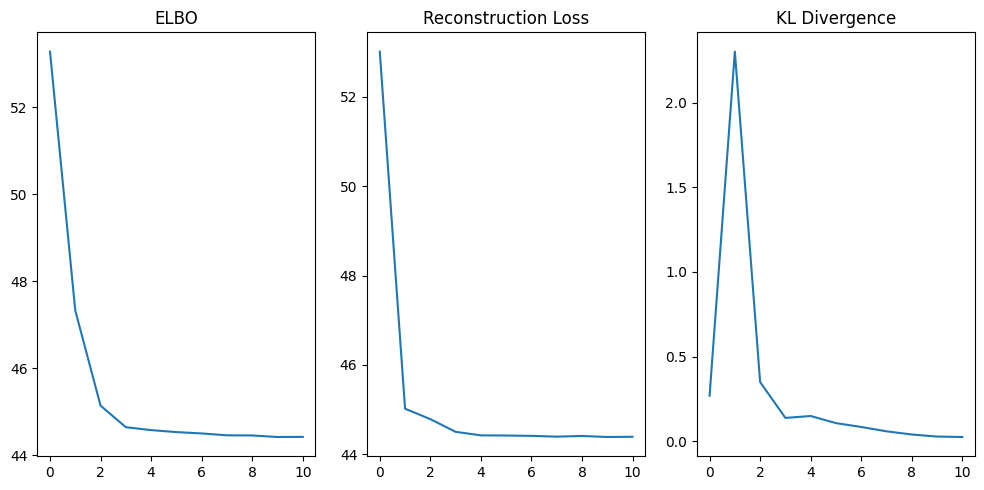

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(elbo_values)
plt.title('ELBO')

plt.subplot(1, 3, 2)
plt.plot(recon_loss_values)
plt.title('Reconstruction Loss')

plt.subplot(1, 3, 3)
plt.plot(kl_values)
plt.title('KL Divergence')

plt.tight_layout()
plt.show()

In [86]:
print("Input image shape:", dummy_x.shape)


Input image shape: (64, 1, 28, 28)


In [60]:
import pdb

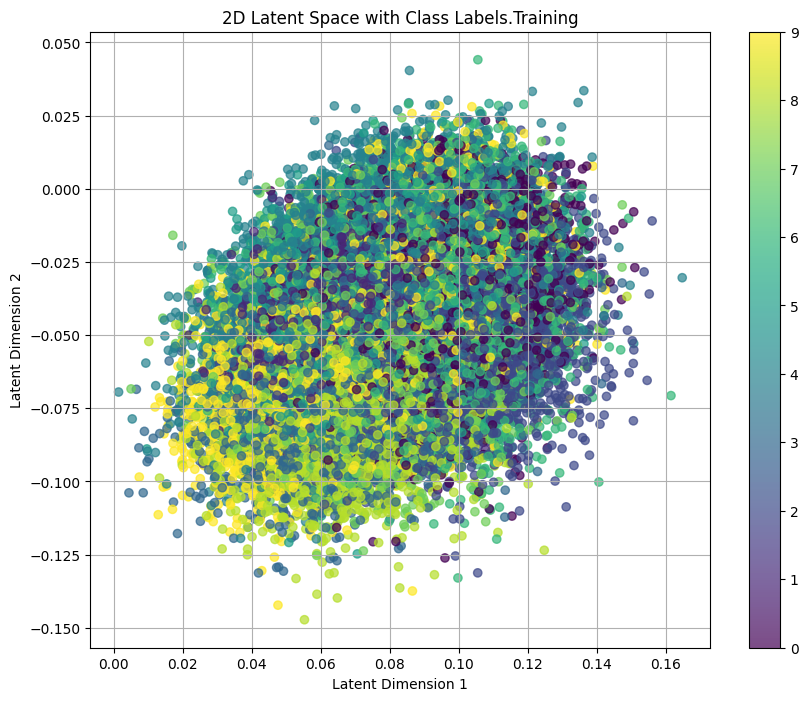

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def encode_data(model, dataloader):
    mus = []
    class_labels = []  # To store the class labels
    for batch in dataloader:
        data, labels = batch

        if not isinstance(data, jnp.ndarray):
            data = jnp.array(data)

        for i in range(data.shape[0]):  # Loop through each data point in the batch
            single_data = data[i].flatten()
            mu, _ = model.en(single_data)
            mus.append(mu)
            class_labels.append(labels[i])  # Append the corresponding label

    return np.vstack(mus), np.array(class_labels)

latent_vars, class_labels = encode_data(vae, trainloader)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vars[:, 0], latent_vars[:, 1], c=class_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(np.max(class_labels)+1))
plt.title('2D Latent Space with Class Labels.Training')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

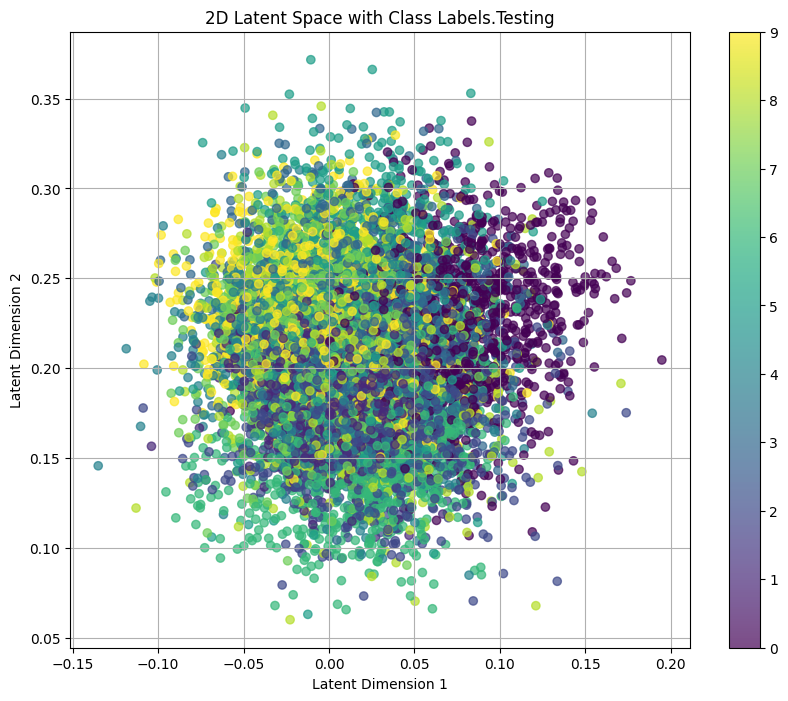

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def encode_data(model, dataloader):
    mus = []
    class_labels = []  # To store the class labels
    for batch in dataloader:
        data, labels = batch

        if not isinstance(data, jnp.ndarray):
            data = jnp.array(data)

        for i in range(data.shape[0]):  # Loop through each data point in the batch
            single_data = data[i].flatten()
            mu, _ = model.en(single_data)
            mus.append(mu)
            class_labels.append(labels[i])  # Append the corresponding label

    return np.vstack(mus), np.array(class_labels)

latent_vars, class_labels = encode_data(vae, testloader)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vars[:, 0], latent_vars[:, 1], c=class_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(np.max(class_labels)+1))
plt.title('2D Latent Space with Class Labels.Testing')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

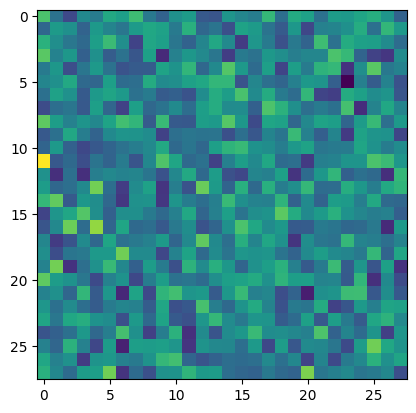

In [88]:
import numpy as np

sample_vector = np.array([1,-1])
decoded_example = vae.de(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28,28)
plt.imshow(decoded_example_reshaped)
